In [2]:
import pandas as pd
import numpy as np
import os, re
import matplotlib.pyplot as plt
import nltk
import math
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
def sigmoid(x):
    return 1 / (1 + math.e ** -x)

In [4]:
os.chdir(r'E:\Hackathon\Beer_dataset_Machine_hack')

In [5]:
train_data=pd.read_csv('train_cleaned.csv')
test_data=pd.read_csv('test_cleaned.csv')
train_data.shape, test_data.shape

((185643, 18), (20628, 18))

In [6]:
# Load the submission file and convert the scores to array
y_act_final=pd.read_excel('Beer_Sample_Submission.xlsx',sheet_name='Sheet1')
y_act_score=y_act_final.Score
y_act_score=np.array(y_act_score)

In [7]:
train_data['glassware_len']=[len(i) for i in train_data['Glassware Used']]
test_data['glassware_len']=[len(i) for i in test_data['Glassware Used']]

In [8]:
# Proper categorization is required
train_data['Ratings'].describe()

count    185643.000000
mean         32.955210
std         254.863803
min           0.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       16954.000000
Name: Ratings, dtype: float64

In [9]:
# Quantile cut to divide into various classes
train_data['ratings_cat']=pd.qcut(train_data['Ratings'], q=[0,0.25,0.5,0.75, 1], labels=['A', 'B','C', 'D'])
test_data['ratings_cat']=pd.qcut(test_data['Ratings'], q=[0,0.25,0.5,0.75, 1], labels=['A', 'B','C', 'D'])

In [10]:
# This looks reasonable
train_data['ABV'].describe()

count    185643.000000
mean          6.354961
std           1.827834
min           0.010000
25%           5.100000
50%           6.100000
75%           7.000000
max          80.000000
Name: ABV, dtype: float64

In [11]:
train_data.head()

,Unnamed: 0,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,Score,style_len,min_cellar_temp,max_cellar_temp,min_serving_temp,max_serving_temp,item_score,glass_score,glassware_len,ratings_cat
0,0,6.500000,8929,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",15121,22,AmericanIPA,40-45,45-50,3.28,11,40,45,45,50,3.0,2.0,53,D
1,1,5.500000,13187,"(PanAsian)Cheese(earthyCamembert,Fontina,nutty...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",59817,1,AmericanPaleAle(APA),35-40,40-45,3.52,20,35,40,40,45,4.0,2.0,53,A
2,2,8.100000,6834,"Meat(Pork,Poultry)","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",32669,3,IrishRedAle,35-40,40-45,4.01,11,35,40,40,45,1.0,2.0,53,C
3,3,6.354961,11688,"(Indian,LatinAmerican,PanAsian)General(Aperitif)","PintGlass(orBecker,Nonic,Tumbler),PilsenerGlas...",130798,0,AmericanMaltLiquor,35-40,35-40,0.00,18,35,40,35,40,2.0,3.0,76,A
4,4,6.000000,10417,"Meat(Poultry,Fish,Shellfish)",PilsenerGlass(orPokal),124087,1,EuroPaleLager,35-40,40-45,2.73,13,35,40,40,45,1.0,1.0,22,A


In [12]:
test_data.head()

,Unnamed: 0,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,Score,style_len,min_cellar_temp,max_cellar_temp,min_serving_temp,max_serving_temp,item_score,glass_score,glassware_len,ratings_cat
0,0,6.2,8803,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",34558,3,AmericanIPA,40-45,45-50,NaN,11,40,45,45,50,3.0,2.0,53,C
1,1,5.3,8558,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",86826,20,AmericanPorter,40-45,45-50,NaN,14,40,45,45,50,4.0,2.0,53,D
2,2,7.0,7519,"Cheese(earthyCamembert,Fontina)General(Aperitif)","Snifter,Tulip,OversizedWineGlass",17051,0,BelgianDarkAle,45-50,45-50,NaN,14,45,50,45,50,2.0,3.0,32,A
3,3,5.2,9852,"(LatinAmerican,German)Meat(Pork,Poultry)","Flute,PilsenerGlass(orPokal),Mug(orSeidel,Stein)",49156,2,ViennaLager,35-40,40-45,NaN,11,35,40,40,45,2.0,3.0,48,B
4,4,8.1,8991,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",162723,5,AmericanPorter,40-45,45-50,NaN,14,40,45,45,50,4.0,2.0,53,C


In [13]:
#train_data_1=pd.get_dummies(train_data['ratings_cat'])
#test_data_1=pd.get_dummies(test_data['ratings_cat'])

In [14]:
#train_data=train_data.join(train_data_1)
#test_data=test_data.join(test_data_1)

In [15]:
train_data['style_name_mod']=[re.findall('[A-Z][^A-Z-(]*', i)[0] for i in train_data['Style Name']]

In [16]:
style_df=train_data.groupby('style_name_mod').agg({"style_name_mod":'count', 'ABV':'mean'}).sort_values(by='style_name_mod',\
                                                                                                              ascending=False)

In [17]:
style_df['cum_sum']=style_df['style_name_mod'].cumsum()
style_df['cum_percentage']=(100*style_df['style_name_mod'].cumsum())/style_df['style_name_mod'].sum()

In [18]:
style_df.head(20)

,style_name_mod,ABV,cum_sum,cum_percentage
style_name_mod,,,,
American,99118,6.703907,99118,53.391725
English,10182,5.443981,109300,58.876446
Saison,8982,6.150862,118282,63.714764
Belgian,7392,7.122550,125674,67.696600
Fruit,4088,5.382545,129762,69.898676
Euro,3867,5.601643,133629,71.981707
Hefeweizen,3670,5.302382,137299,73.958620
Witbier,3265,5.304410,140564,75.717372
German,2955,5.171126,143519,77.309136


In [19]:
test_data['style_name_mod']=[re.findall('[A-Z][^A-Z-(]*', i)[0] for i in test_data['Style Name']]

In [20]:
test_data.head()

,Unnamed: 0,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,...,style_len,min_cellar_temp,max_cellar_temp,min_serving_temp,max_serving_temp,item_score,glass_score,glassware_len,ratings_cat,style_name_mod
0,0,6.2,8803,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",34558,3,AmericanIPA,40-45,45-50,...,11,40,45,45,50,3.0,2.0,53,C,American
1,1,5.3,8558,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",86826,20,AmericanPorter,40-45,45-50,...,14,40,45,45,50,4.0,2.0,53,D,American
2,2,7.0,7519,"Cheese(earthyCamembert,Fontina)General(Aperitif)","Snifter,Tulip,OversizedWineGlass",17051,0,BelgianDarkAle,45-50,45-50,...,14,45,50,45,50,2.0,3.0,32,A,Belgian
3,3,5.2,9852,"(LatinAmerican,German)Meat(Pork,Poultry)","Flute,PilsenerGlass(orPokal),Mug(orSeidel,Stein)",49156,2,ViennaLager,35-40,40-45,...,11,35,40,40,45,2.0,3.0,48,B,Vienna
4,4,8.1,8991,"(Barbecue)Cheese(butteryBrie,Gouda,Havarti,Swi...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",162723,5,AmericanPorter,40-45,45-50,...,14,40,45,45,50,4.0,2.0,53,C,American


In [21]:
train_data['ABV_cat']=pd.qcut(train_data['ABV'], q=[0,0.25,0.5,0.75, 1], labels=['Light', 'Medium','Strong', 'Super_Strong'])
test_data['ABV_cat']=pd.qcut(test_data['ABV'], q=[0,0.25,0.5,0.75, 1], labels=['Light', 'Medium','Strong', 'Super_Strong'])

In [22]:
train_data['ABV_score_cat']=[25 if i in ['Light']\
                            else 50 if i in ['Medium']\
                            else 75 if i in ['Strong']\
                            else 100 for i in train_data['ABV_cat']]
test_data['ABV_score_cat']=[25 if i in ['Light']\
                            else 50 if i in ['Medium']\
                            else 75 if i in ['Strong']\
                            else 100 for i in test_data['ABV_cat']]

In [23]:
#abv_cat_train=pd.get_dummies(train_data['ABV_cat'])
#train_data=train_data.join(abv_cat_train)
#abv_cat_test=pd.get_dummies(test_data['ABV_cat'])
#test_data=test_data.join(abv_cat_test)

In [24]:
train_data.head()

,Unnamed: 0,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,...,max_cellar_temp,min_serving_temp,max_serving_temp,item_score,glass_score,glassware_len,ratings_cat,style_name_mod,ABV_cat,ABV_score_cat
0,0,6.500000,8929,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",15121,22,AmericanIPA,40-45,45-50,...,45,45,50,3.0,2.0,53,D,American,Strong,75
1,1,5.500000,13187,"(PanAsian)Cheese(earthyCamembert,Fontina,nutty...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",59817,1,AmericanPaleAle(APA),35-40,40-45,...,40,40,45,4.0,2.0,53,A,American,Medium,50
2,2,8.100000,6834,"Meat(Pork,Poultry)","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",32669,3,IrishRedAle,35-40,40-45,...,40,40,45,1.0,2.0,53,C,Irish,Super_Strong,100
3,3,6.354961,11688,"(Indian,LatinAmerican,PanAsian)General(Aperitif)","PintGlass(orBecker,Nonic,Tumbler),PilsenerGlas...",130798,0,AmericanMaltLiquor,35-40,35-40,...,40,35,40,2.0,3.0,76,A,American,Strong,75
4,4,6.000000,10417,"Meat(Poultry,Fish,Shellfish)",PilsenerGlass(orPokal),124087,1,EuroPaleLager,35-40,40-45,...,40,40,45,1.0,1.0,22,A,Euro,Medium,50


In [25]:
# Pereto to consider the 80% of data datapoint to improve accuracy
train_data['country_style']=['American' if i in ['American']\
                                       else 'English' if i in ['English']\
                                       else 'Saison' if i in ['Saison']\
                                       else 'Belgian' if i in ['Belgian']\
                                       else 'Fruit' if i in ['Fruit']\
                                       else 'Euro' if i in ['Euro']\
                                       else 'Hefeweizen' if i in ['Hefeweizen']\
                                       else 'Witbier' if i in ['Witbier']\
                                       else 'German' if i in ['German']\
                                       else 'Irish' if i in ['Irish']\
                                       else 'Berliner' if i in ['Berliner']\
                                       else 'Mrzen' if i in ['Mrzen']\
                                       else 'others' for i in train_data['style_name_mod']]

In [26]:
# Pereto to consider the 80% of data datapoint to improve accuracy
test_data['country_style']=['American' if i in ['American']\
                                       else 'English' if i in ['English']\
                                       else 'Saison' if i in ['Saison']\
                                       else 'Belgian' if i in ['Belgian']\
                                       else 'Fruit' if i in ['Fruit']\
                                       else 'Euro' if i in ['Euro']\
                                       else 'Hefeweizen' if i in ['Hefeweizen']\
                                       else 'Witbier' if i in ['Witbier']\
                                       else 'German' if i in ['German']\
                                       else 'Irish' if i in ['Irish']\
                                       else 'Berliner' if i in ['Berliner']\
                                       else 'Mrzen' if i in ['Mrzen']\
                                       else 'others' for i in test_data['style_name_mod']]

In [27]:
country_dummies_train=pd.get_dummies(train_data['country_style'])
country_dummies_test=pd.get_dummies(test_data['country_style'])

In [28]:
# Join if needed only
#train_data=train_data.join(country_dummies_train)
#test_data=test_data.join(country_dummies_test)

In [29]:
train_data.shape

(185643, 24)

In [30]:
# Beer types referred from http://www.thebeerstore.ca/beer-101/beer-types
beer_types=['Ales','Lagers','Stouts & Porters', 'Malts']
beer_brew_styles=['Amber','Blonde','Brown','Cream','Dark','Fruit','Golden','Honey','IPA','Light','Lime','Pale','Pilsner',\
            'Red','Strong','Wheat']

In [31]:
re.findall('[A-Z][^A-Z-(]*', train_data['Style Name'][1])

['American', 'Pale', 'Ale', 'A', 'P', 'A)']

In [32]:
# Mostly Grouped based on secondary research (Google search- Wikipedia Source)
def beer_type_cateorizer(data_frame):
    beer_type_cat=[]
    for xd in range(len(data_frame['Style Name'])):
        split_by_cap=re.findall('[A-Z][^A-Z-(]*', data_frame['Style Name'][xd])
        if split_by_cap[-1]=='A':
            beer_type_cat.append('Ales')
        elif 'Ale' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Malt' in split_by_cap:
            beer_type_cat.append('Malts')
        elif 'Lager' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Stout' in split_by_cap:
            beer_type_cat.append('Stouts_and_Porters')
        elif 'Porter' in split_by_cap:
            beer_type_cat.append('Stouts_and_Porters')
        elif 'Tan' in split_by_cap:
            beer_type_cat.append('Stouts_and_Porters')
        elif 'Bitter' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Bock' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Eisbock' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Weizenbock' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Kvass' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Roggenbier' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Schwarzbier' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Garde' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Pilsener' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Mrzen' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Doppelbock' in split_by_cap:
            beer_type_cat.append('Lagers')
        elif 'Smoked' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Weissbier' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Fruit' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Dubbel' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Barley' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Witbier' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Klsch' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Tripel' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Gose' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Low' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Rauchbier' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Barleywine' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Hefeweizen' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Quadrupel' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Spiced' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Zwickelbier' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Rye' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Sahti' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Steam' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Altbier' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Flanders' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Dunkelweizen' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Kristalweizen' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Wheatwine' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Chile' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Imperial' in split_by_cap:
            beer_type_cat.append('Ales')
        elif 'Gueuze' in split_by_cap:
            beer_type_cat.append('Ales')
        else:
            beer_type_cat.append('mixed_style')
    data_frame['beer_category_group']=beer_type_cat
    return data_frame

In [33]:
# The function ads new column to the dataframe train/test
train_data=beer_type_cateorizer(data_frame=train_data)
test_data=beer_type_cateorizer(data_frame=test_data)

In [34]:
train_data.loc[train_data['beer_category_group']=='mixed_style']['Style Name'].unique()

array(['Happoshu', 'Braggot', 'BiredeChampagneBireBrut',
       'Lambic-Unblended', 'Faro'], dtype=object)

In [35]:
train_data.groupby(['beer_category_group']).agg({'Ratings':['count','min', 'mean','median','max']})

Ratings                             
                      count min       mean median    max
beer_category_group                                     
Ales                 135449   0  32.456142      2  15787
Lagers                24150   0  30.616356      2   9327
Malts                   247   0  50.295547      4   1303
Stouts_and_Porters    25410   0  37.742109      2  16954
mixed_style             387   0  28.209302      3   2106

In [36]:
train_data.groupby(['beer_category_group']).agg({'ABV':['count','min', 'mean','median','max']})

ABV                                
                      count   min      mean    median   max
beer_category_group                                        
Ales                 135449  0.01  6.313006  6.200000  75.0
Lagers                24150  0.50  5.642465  5.300000  57.5
Malts                   247  4.00  7.858317  8.000000  16.5
Stouts_and_Porters    25410  1.90  7.226596  6.354961  80.0
mixed_style             387  2.00  7.310786  6.354961  17.0

In [37]:
train_data['colour']='yellow'
train_data.loc[train_data['beer_category_group']=='Ales','colour']='blue'
train_data.loc[train_data['beer_category_group']=='Malts','colour']='brown'
train_data.loc[train_data['beer_category_group']=='Lagers','colour']='red'
train_data.loc[train_data['beer_category_group']=='Stouts_and_Porters','colour']='green'

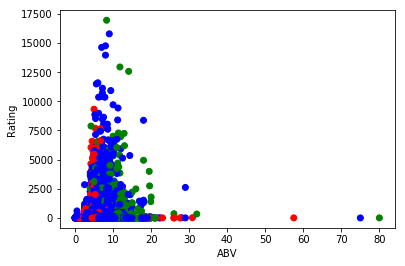

In [38]:
plt.scatter(x=train_data['ABV'], y=train_data['Ratings'], c=train_data['colour'])
plt.xlabel('ABV')
plt.ylabel('Rating')
plt.show()

In [39]:
train_data=train_data.loc[train_data['ABV']<=35]

In [40]:
train_data.head()

,Unnamed: 0,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,...,item_score,glass_score,glassware_len,ratings_cat,style_name_mod,ABV_cat,ABV_score_cat,country_style,beer_category_group,colour
0,0,6.500000,8929,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",15121,22,AmericanIPA,40-45,45-50,...,3.0,2.0,53,D,American,Strong,75,American,Ales,blue
1,1,5.500000,13187,"(PanAsian)Cheese(earthyCamembert,Fontina,nutty...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",59817,1,AmericanPaleAle(APA),35-40,40-45,...,4.0,2.0,53,A,American,Medium,50,American,Ales,blue
2,2,8.100000,6834,"Meat(Pork,Poultry)","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",32669,3,IrishRedAle,35-40,40-45,...,1.0,2.0,53,C,Irish,Super_Strong,100,Irish,Ales,blue
3,3,6.354961,11688,"(Indian,LatinAmerican,PanAsian)General(Aperitif)","PintGlass(orBecker,Nonic,Tumbler),PilsenerGlas...",130798,0,AmericanMaltLiquor,35-40,35-40,...,2.0,3.0,76,A,American,Strong,75,American,Malts,brown
4,4,6.000000,10417,"Meat(Poultry,Fish,Shellfish)",PilsenerGlass(orPokal),124087,1,EuroPaleLager,35-40,40-45,...,1.0,1.0,22,A,Euro,Medium,50,Euro,Lagers,red


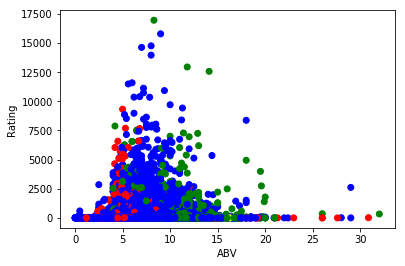

In [41]:
plt.scatter(x=train_data['ABV'], y=train_data['Ratings'], c=train_data['colour'])
plt.xlabel('ABV')
plt.ylabel('Rating')
plt.show()

In [42]:
test_data['colour']='yellow'
test_data.loc[test_data['beer_category_group']=='Ales','colour']='blue'
test_data.loc[test_data['beer_category_group']=='Malts','colour']='brown'
test_data.loc[test_data['beer_category_group']=='Lagers','colour']='red'
test_data.loc[test_data['beer_category_group']=='Stouts_and_Porters','colour']='green'

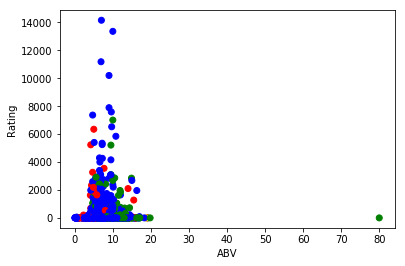

In [43]:
plt.scatter(x=test_data['ABV'], y=test_data['Ratings'], c=test_data['colour'])
plt.xlabel('ABV')
plt.ylabel('Rating')
plt.show()

### Trying to improve relationship between rating and score so avoiding 0 by some imputation

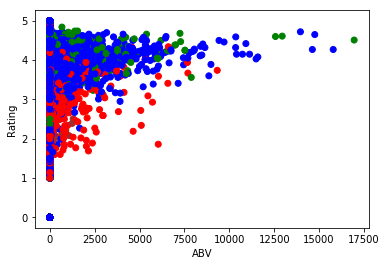

In [45]:
plt.scatter(x=train_data['Ratings'], y=train_data['Score'], c=train_data['colour'])
plt.xlabel('ABV')
plt.ylabel('Rating')
plt.show()

In [47]:
len(train_data.loc[train_data['Ratings']==0])

26089

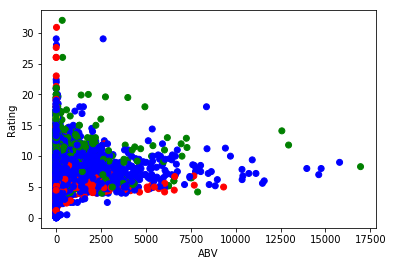

In [48]:
plt.scatter(x=train_data['Ratings'], y=train_data['ABV'], c=train_data['colour'])
plt.xlabel('ABV')
plt.ylabel('Rating')
plt.show()

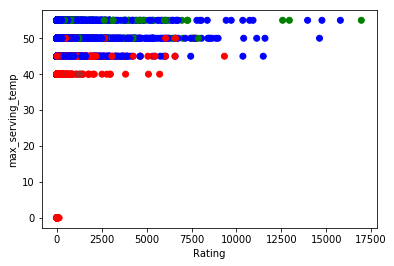

In [49]:
# no relationship between serving temperature and ratings
plt.scatter(x=train_data['Ratings'], y=train_data['max_serving_temp'], c=train_data['colour'])
plt.xlabel('Rating')
plt.ylabel('max_serving_temp')
plt.show()

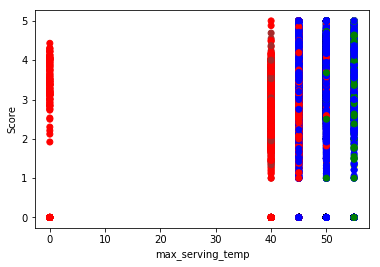

In [50]:
# no relationship between max serving temperature and Score
plt.scatter(x=train_data['max_serving_temp'], y=train_data['Score'], c=train_data['colour'])
plt.xlabel('max_serving_temp')
plt.ylabel('Score')
plt.show()

In [ ]:
# no relationship between max serving temperature and Score
plt.scatter(x=train_data['max_serving_temp'], y=train_data['Score'], c=train_data['colour'])
plt.xlabel('max_serving_temp')
plt.ylabel('Score')
plt.show()

In [ ]:
# Cutting till 14K the ratings.


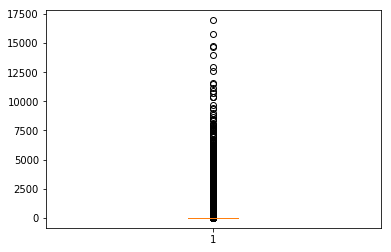

In [106]:
plt.boxplot(train_data['Ratings'])
plt.show()

In [105]:
train_data.groupby('beer_category_group').agg({'ABV':['min','mean','median','max', 'count',np.std], 'Ratings':['min','mean','median','max', 'count',np.std]})

ABV                                               \
                      min      mean    median    max   count       std   
beer_category_group                                                      
Ales                 0.01  6.312499  6.200000  29.00  135448  1.710842   
Lagers               0.50  5.640318  5.300000  30.86   24149  1.361049   
Malts                4.00  7.858317  8.000000  16.50     247  1.987208   
Stouts_and_Porters   1.90  7.223732  6.354961  32.00   25409  2.259977   
mixed_style          2.00  7.310786  6.354961  17.00     387  2.731677   

                    Ratings                                               
                        min       mean median    max   count         std  
beer_category_group                                                       
Ales                      0  32.456382      2  15787  135448  252.033468  
Lagers                    0  30.617458      2   9327   24149  221.697686  
Malts                     0  50.295547      4   1303     247  167.126205  
Stouts_and_Porters        0  37.743516      2  16954   25409  297.761592  
mixed_style               0  28.209302      3   2106     387  139.105079

In [38]:
rat_df=pd.DataFrame(train_data.groupby('beer_category_group').agg({'Ratings':['mean', np.std]}))

In [39]:
rat_df

Ratings            
                          mean         std
beer_category_group                       
Ales                 32.456142  252.032554
Lagers               30.616356  221.693162
Malts                50.295547  167.126205
Stouts_and_Porters   37.742109  297.755817
mixed_style          28.209302  139.105079

In [40]:
# To get a normalized score- from ratings by (mean + 3 times sigma =rank type of beer)
ales_rank=int((rat_df.iloc[0][0])+3*(rat_df.iloc[0][1]))
lagers_rank=int((rat_df.iloc[1][0])+3*(rat_df.iloc[1][1]))
malts_rank=int((rat_df.iloc[2][0])+3*(rat_df.iloc[2][1]))
stpt_rank=int((rat_df.iloc[3][0])+3*(rat_df.iloc[3][1]))
unkn_rank=int((rat_df.iloc[4][0])+3*(rat_df.iloc[4][1]))
(ales_rank,lagers_rank,malts_rank,stpt_rank,unkn_rank)

(788, 695, 551, 931, 445)

In [41]:
train_data['type_beer_rank']=[ales_rank if i in ['Ales']\
                             else lagers_rank if i in ['Lagers']\
                             else malts_rank if i in ['Malts']\
                             else stpt_rank if i in ['Stouts_and_Porters']
                             else unkn_rank for i in train_data['beer_category_group']]
test_data['type_beer_rank']=[ales_rank if i in ['Ales']\
                             else lagers_rank if i in ['Lagers']\
                             else malts_rank if i in ['Malts']\
                             else stpt_rank if i in ['Stouts_and_Porters']
                             else unkn_rank for i in test_data['beer_category_group']]

In [42]:
train_data.head()

,Unnamed: 0,ABV,Brewing Company,Food Paring,Glassware Used,Beer Name,Ratings,Style Name,Cellar Temperature,Serving Temperature,...,item_score,glass_score,glassware_len,ratings_cat,style_name_mod,ABV_cat,ABV_score_cat,country_style,beer_category_group,type_beer_rank
0,0,6.500000,8929,"(Curried,Thai)Cheese(pepperyMontereyPepperJack...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",15121,22,AmericanIPA,40-45,45-50,...,3.0,2.0,53,D,American,Strong,75,American,Ales,788
1,1,5.500000,13187,"(PanAsian)Cheese(earthyCamembert,Fontina,nutty...","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",59817,1,AmericanPaleAle(APA),35-40,40-45,...,4.0,2.0,53,A,American,Medium,50,American,Ales,788
2,2,8.100000,6834,"Meat(Pork,Poultry)","PintGlass(orBecker,Nonic,Tumbler),Mug(orSeidel...",32669,3,IrishRedAle,35-40,40-45,...,1.0,2.0,53,C,Irish,Super_Strong,100,Irish,Ales,788
3,3,6.354961,11688,"(Indian,LatinAmerican,PanAsian)General(Aperitif)","PintGlass(orBecker,Nonic,Tumbler),PilsenerGlas...",130798,0,AmericanMaltLiquor,35-40,35-40,...,2.0,3.0,76,A,American,Strong,75,American,Malts,551
4,4,6.000000,10417,"Meat(Poultry,Fish,Shellfish)",PilsenerGlass(orPokal),124087,1,EuroPaleLager,35-40,40-45,...,1.0,1.0,22,A,Euro,Medium,50,Euro,Lagers,695


In [43]:
train_data_final=train_data.drop(labels=['Unnamed: 0','Style Name','Beer Name','Brewing Company','max_cellar_temp','style_name_mod','country_style',\
                                        'max_serving_temp', 'ABV_cat','item_score','glassware_len','Food Paring','Glassware Used',\
                                        'Cellar Temperature','Serving Temperature','min_cellar_temp','ratings_cat','beer_category_group'], axis=1)
test_data_final=test_data.drop(labels=['Unnamed: 0','Style Name','Beer Name','Brewing Company','max_cellar_temp','style_name_mod','country_style',\
                                        'max_serving_temp','ABV_cat','item_score','glassware_len','Food Paring','Glassware Used',\
                                        'Cellar Temperature','min_cellar_temp','Serving Temperature','ratings_cat','beer_category_group'], axis=1)

In [44]:
train_data_final['abv_sq']=train_data_final['ABV']*train_data_final['ABV']
test_data_final['abv_sq']=test_data_final['ABV']*test_data_final['ABV']

In [45]:
train_data_final['style_len_sq']=train_data_final['style_len']*train_data_final['style_len']
test_data_final['style_len_sq']=test_data_final['style_len']*test_data_final['style_len']

In [46]:
train_data_final.head()

,ABV,Ratings,Score,style_len,min_serving_temp,glass_score,ABV_score_cat,type_beer_rank,abv_sq,style_len_sq
0,6.500000,22,3.28,11,45,2.0,75,788,42.250000,121
1,5.500000,1,3.52,20,40,2.0,50,788,30.250000,400
2,8.100000,3,4.01,11,40,2.0,100,788,65.610000,121
3,6.354961,0,0.00,18,35,3.0,75,551,40.385526,324
4,6.000000,1,2.73,13,40,1.0,50,695,36.000000,169


In [47]:
train_data_final=train_data_final.drop(labels='style_len', axis=1)
test_data_final=test_data_final.drop(labels='style_len', axis=1)

In [48]:
train_data_final.corr()

,ABV,Ratings,Score,min_serving_temp,glass_score,ABV_score_cat,type_beer_rank,abv_sq,style_len_sq
ABV,1.000000,0.053559,0.130498,0.461440,0.302961,0.845765,0.206959,0.854971,0.326566
Ratings,0.053559,1.000000,0.065293,0.028100,0.025692,0.037036,0.007258,0.045331,0.027740
Score,0.130498,0.065293,1.000000,0.124193,0.077039,0.119804,0.082135,0.095454,0.061912
min_serving_temp,0.461440,0.028100,0.124193,1.000000,0.290187,0.417515,0.355288,0.353417,0.219006
glass_score,0.302961,0.025692,0.077039,0.290187,1.000000,0.271135,-0.010040,0.231480,0.348674
ABV_score_cat,0.845765,0.037036,0.119804,0.417515,0.271135,1.000000,0.182631,0.603567,0.240830
type_beer_rank,0.206959,0.007258,0.082135,0.355288,-0.010040,0.182631,1.000000,0.162250,0.123494
abv_sq,0.854971,0.045331,0.095454,0.353417,0.231480,0.603567,0.162250,1.000000,0.268418
style_len_sq,0.326566,0.027740,0.061912,0.219006,0.348674,0.240830,0.123494,0.268418,1.000000


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Model Packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

def model_eval(train_data, regressor, final_test_set, actual_score):
    y=train_data['Score']
    X=train_data.drop(labels=['Score'], axis=1)
    
    # Split the train data to train-test split
    X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=45)
    
    # Training model object
    print('Training the model with 80-20 Split.....')
    regr=regressor
    model_obj=regr.fit(X_train, y_train)
    y_pred=model_obj.predict(X_test)
    y_act=y_test
    mean_abs_err=mean_absolute_error(y_act, y_pred)
    root_mean_sqr_err=sqrt(mean_squared_error(y_act, y_pred))
    print('RMSE_Train_model: ', root_mean_sqr_err)
    sigmoid_value=sigmoid(root_mean_sqr_err)
    print('Score_trained_model: ',(1-sigmoid_value))
    
    # Final test set
    pred_score=model_obj.predict(final_test_set.drop(labels='Score', axis=1))
    root_mean_sqr_err_final=sqrt(mean_squared_error(actual_score, pred_score))
    print('RMSE_Test_set: ', root_mean_sqr_err_final)
    sigmoid_value_test=sigmoid(root_mean_sqr_err_final)
    print('Score_on_test_set: ',(1-sigmoid_value_test))
    
    return pred_score

In [50]:
pred_score_lreg=model_eval(train_data=train_data_final, regressor=LinearRegression(), final_test_set=test_data_final,\
           actual_score=y_act_score)

Training the model with 80-20 Split.....
RMSE_Train_model:  1.3334686713102677
Score_trained_model:  0.20858618512391702
RMSE_Test_set:  1.5899096054105908
Score_on_test_set:  0.1693966151993871


In [51]:
pred_score_rforest=model_eval(train_data=train_data_final, regressor=RandomForestRegressor(), final_test_set=test_data_final,\
           actual_score=y_act_score)

Training the model with 80-20 Split.....
RMSE_Train_model:  0.378778309711891
Score_trained_model:  0.4064215876678642
RMSE_Test_set:  2.0624075783574827
Score_on_test_set:  0.11280465548818319


In [52]:
pred_score_gbm=model_eval(train_data=train_data_final, regressor=GradientBoostingRegressor(), final_test_set=test_data_final,\
           actual_score=y_act_score)

Training the model with 80-20 Split.....
RMSE_Train_model:  0.36587535227101264
Score_trained_model:  0.40953805657813225
RMSE_Test_set:  2.050661151831953
Score_on_test_set:  0.11398559261097829


In [53]:
pred_score_xgb=model_eval(train_data=train_data_final, regressor=XGBRegressor(), final_test_set=test_data_final,\
           actual_score=y_act_score)

Training the model with 80-20 Split.....
RMSE_Train_model:  0.3659764244485401
Score_trained_model:  0.40951361586757606
RMSE_Test_set:  2.050599278808863
Score_on_test_set:  0.11399184149485231


### ANN to improve accuracy

In [54]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [55]:
# Train and test split
from sklearn.model_selection import train_test_split

y=train_data_final['Score']
X=train_data_final.drop(labels='Score', axis=1)

# 80-20 Split for modelling with ann
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=31)

In [56]:
X_train.shape, X_test.shape

((148514, 8), (37129, 8))

In [57]:
# Intializing ANN
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [63]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [ ]:
# 5-fold cross validation to evaluate the model
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [58]:
ann_model=baseline_model()

In [59]:
ann_model.fit(X_train, y_train, epochs=100, batch_size=5)

Epoch 1/100
148514/148514 [==============================] - 43s 291us/step - loss: 1.4178
Epoch 2/100
148514/148514 [==============================] - 42s 285us/step - loss: 1.8295
Epoch 3/100
148514/148514 [==============================] - 42s 282us/step - loss: 1.8226
Epoch 4/100
148514/148514 [==============================] - 43s 287us/step - loss: 1.8175
Epoch 5/100
148514/148514 [==============================] - 42s 286us/step - loss: 1.4799
Epoch 6/100
148514/148514 [==============================] - 44s 294us/step - loss: 0.9995
Epoch 7/100
148514/148514 [==============================] - 43s 291us/step - loss: 1.8266
Epoch 8/100
148514/148514 [==============================] - 44s 293us/step - loss: 1.8249
Epoch 9/100
148514/148514 [==============================] - 45s 304us/step - loss: 1.8237
Epoch 10/100
148514/148514 [==============================] - 44s 297us/step - loss: 1.8227
Epoch 11/100
148514/148514 [==============================] - 44s 299us/step - loss: 1.82

Epoch 90/100
148514/148514 [==============================] - 38s 258us/step - loss: 1.8518
Epoch 91/100
148514/148514 [==============================] - 38s 258us/step - loss: 1.8519
Epoch 92/100
148514/148514 [==============================] - 38s 259us/step - loss: 1.8518
Epoch 93/100
148514/148514 [==============================] - 38s 258us/step - loss: 1.8519
Epoch 94/100
148514/148514 [==============================] - 38s 258us/step - loss: 1.8518
Epoch 95/100
148514/148514 [==============================] - 38s 257us/step - loss: 1.8519
Epoch 96/100
148514/148514 [==============================] - 37s 251us/step - loss: 1.8519
Epoch 97/100
148514/148514 [==============================] - 36s 244us/step - loss: 1.8518
Epoch 98/100
148514/148514 [==============================] - 36s 244us/step - loss: 1.8517
Epoch 99/100
148514/148514 [==============================] - 36s 245us/step - loss: 1.8517
Epoch 100/100
148514/148514 [==============================] - 36s 245us/step - 

In [60]:
# Known 80-20 Split:
y_pred_1=ann_model.predict(X_test)
root_mean_sqr_err_ann=sqrt(mean_squared_error(y_test, y_pred_1))
root_mean_sqr_err_ann

1.351779124891783

In [69]:
# Unknown dataset
y_pred_unknown=ann_model.predict(test_data_final.drop(labels='Score', axis=1))
root_mean_sqr_err_ann_unknown=sqrt(mean_squared_error(y_act_score, y_pred_unknown))
root_mean_sqr_err_ann_unknown

1.5609953472369356

In [70]:
y_pred_unknown

array([[3.1758146],
       [3.1758146],
       [3.1758146],
       ...,
       [3.1758146],
       [3.1758146],
       [3.1758146]], dtype=float32)

### Building CNN

In [1]:
from keras import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

C:\Users\Arunachalam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# Intializing CNN
def baseline_cnn_model():
    # create model
    model = Sequential()
    
    # Adding layers of CNN - convolution -> Max pooling -> Flattening -> Full connection(Hidden layer)
    model.add(Convolution2D(32, 3, 3, input_shape=(64,64, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), ))
    model.add(Flatten())
    model.add(Dense(output_dim= 128, activation='relu')) # choose number based on input values (hidden nodes in hidden layer)
    model.add(Dense(output_dim= 1, activation='sigmoid')) # sigmoid for binary outcome
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    
    return model

### Saving to Submission Format

In [62]:
final_sub=pd.DataFrame(columns=['Score'])

In [82]:
final_sub['Score']=y_pred_unknown

In [83]:
writer = pd.ExcelWriter('output_ann.xlsx')
final_sub.to_excel(writer,'Sheet1', index= False)
writer.save()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

y=train_data_final['Score']
X=train_data_final.drop(labels=['Score'], axis=1)

# Split the train data to train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=45)

# Training model object
regressor=LinearRegression()
model_obj=regressor.fit(X_train, y_train)
y_pred=model_obj.predict(X_test)
y_act=y_test
mean_abs_err=mean_absolute_error(y_act, y_pred)
root_mean_sqr_err=sqrt(mean_squared_error(y_act, y_pred))

print('Mean absolute error: ', mean_abs_err)
print('Root Mean squared error: ', root_mean_sqr_err)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

y=train_data_final['Score']
X=train_data_final.drop(labels=['Score'], axis=1)

# Split the train data to train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=45)

# Training model object
regressor=RandomForestRegressor()
model_obj=regressor.fit(X_train, y_train)
y_pred=model_obj.predict(X_test)
y_act=y_test
mean_abs_err=mean_absolute_error(y_act, y_pred)
root_mean_sqr_err=sqrt(mean_squared_error(y_act, y_pred))

print('Mean absolute error: ', mean_abs_err)
print('Root Mean squared error: ', root_mean_sqr_err)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

y=train_data_final['Score']
X=train_data_final.drop(labels=['Score'], axis=1)

# Split the train data to train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=45)

# Training model object
regressor=GradientBoostingRegressor()
model_obj=regressor.fit(X_train, y_train)
y_pred=model_obj.predict(X_test)
y_act=y_test
mean_abs_err=mean_absolute_error(y_act, y_pred)
root_mean_sqr_err=sqrt(mean_squared_error(y_act, y_pred))

print('Mean absolute error: ', mean_abs_err)
print('Root Mean squared error: ', root_mean_sqr_err)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

y=train_data_final['Score']
X=train_data_final.drop(labels=['Score'], axis=1)

# Split the train data to train-test split
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=45)

# Training model object
regressor=XGBRegressor()
model_obj_xgb=regressor.fit(X_train, y_train)
y_pred=model_obj_xgb.predict(X_test)
y_act=y_test
mean_abs_err=mean_absolute_error(y_act, y_pred)
root_mean_sqr_err=sqrt(mean_squared_error(y_act, y_pred))

print('Mean absolute error: ', mean_abs_err)
print('Root Mean squared error: ', root_mean_sqr_err)

### Predictions on the test dataset

In [ ]:
y_pred_final=model_obj_xgb.predict(test_data_final.drop(labels='Score', axis=1))

In [ ]:
y_pred_final

In [ ]:

root_mean_sqr_err_final=sqrt(mean_squared_error(y_act_score, y_pred_final))
sigmoid_value=sigmoid(root_mean_sqr_err_final)
print('Score: ',(1-sigmoid_value))

In [ ]:
sigmoid_value=sigmoid(0.36714119973700055)
print('Score: ',(1-sigmoid_value))

In [ ]:
1-0.88

### Grid Search - GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

param_test1 = {'n_estimators':[50, 100, 300], 'min_samples_leaf':[10, 50, 70], 'learning_rate':[0.01, 0.05, 0.1],'max_depth ':[2, 3, 5]}

gbm = GradientBoostingRegressor(random_state=10)

gsearch1 = GridSearchCV(estimator=gbm, param_grid = param_test1, scoring='explained_variance', cv=5)

In [ ]:
gsearch1.fit(X_train, y_train.values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
X_train.values

In [ ]:
X_train.head()